In [38]:
!pip install ultralytics roboflow numpy matplotlib opencv-python scikit-learn

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from roboflow import Roboflow

rf = Roboflow(api_key="gwLvRTOEwowJxx2CPf2g")
project = rf.workspace("ehealthia").project("chest-x-ray-17-diseases")
version = project.version(1)
dataset = version.download("folder")  # classification format since YOLOv8 supports folder classification


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Chest-X-ray---17-Diseases-1 in folder:: 100%|██████████| 289/289 [00:00<00:00, 3941.17it/s]


In [4]:
import os

data_path = dataset.location
print("Dataset Path:", data_path)

print("\nClasses:", os.listdir(f"{data_path}/train"))


Dataset Path: /content/Chest-X-ray---17-Diseases-1

Classes: ['pneumosclerosis', 'hydrothorax', 'post_inflammatory_changes', 'abscess', 'hydropneumothorax', 'post_traumatic_ribs_deformation', 'fracture', 'cardiomegaly', 'sarcoidosis', 'emphysema', 'scoliosis', 'atherosclerosis_of_the_aorta', 'venous_congestion', 'pneumonia', 'atelectasis', 'tuberculosis']


In [5]:
import shutil, os

drive_path = "/content/drive/MyDrive/Xray_17_Diseases_Dataset"
os.makedirs(drive_path, exist_ok=True)

shutil.copytree(data_path, drive_path, dirs_exist_ok=True)

print("✅ Saved to Google Drive at:", drive_path)

✅ Saved to Google Drive at: /content/drive/MyDrive/Xray_17_Diseases_Dataset


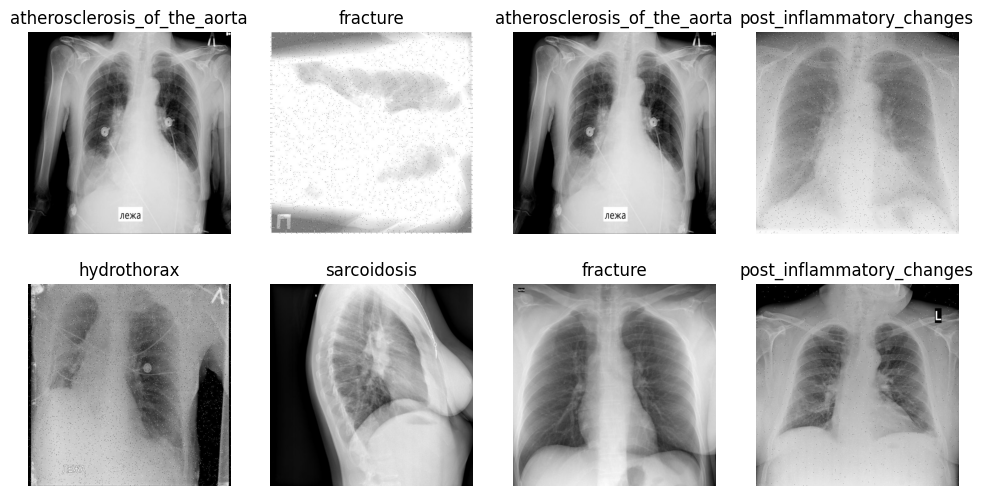

In [21]:
import matplotlib.pyplot as plt
import cv2
import random
import os

# Fix train directory path
train_dir = data_path   # it already points to /train
classes = os.listdir(train_dir)

plt.figure(figsize=(12,6))
for i in range(8):
    cls = random.choice(classes)
    img = random.choice(os.listdir(f"{train_dir}/{cls}"))
    img_path = f"{train_dir}/{cls}/{img}"

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.subplot(2,4,i+1)
    plt.imshow(image)
    plt.title(cls)
    plt.axis("off")
plt.show()


In [22]:
#Train YOLOv8 Classification Model
from ultralytics import YOLO

model = YOLO("yolov8s-cls.pt")  # pretrained classifier model

model.train(
    data=data_path,
    epochs=30,
    imgsz=224,
    batch=16
)


Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Xray_17_Diseases_Dataset/train, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, per

ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78e284bd3da0>
curves: []
curves_results: []
fitness: 0.9811320900917053
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9622641801834106, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9811320900917053}
save_dir: PosixPath('/content/runs/classify/train2')
speed: {'preprocess': 0.0015141792384795582, 'inference': 37.497354547178716, 'loss': 6.834904164655732e-05, 'postprocess': 0.00013211320895967424}
task: 'classify'
top1: 0.9622641801834106
top5: 1.0

In [23]:
results = model.val()
print(results)


Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
YOLOv8s-cls summary (fused): 30 layers, 5,095,696 parameters, 0 gradients, 12.5 GFLOPs
WARNING ⚠️ Dataset 'split=train' not found at /content/drive/MyDrive/Xray_17_Diseases_Dataset/train/train
Found 204 images in subdirectories. Attempting to split...
Splitting /content/drive/MyDrive/Xray_17_Diseases_Dataset/train (16 classes, 204 images) into 80% train, 20% val...
Split complete in /content/drive/MyDrive/Xray_17_Diseases_Dataset/train_split ✅
train: /content/drive/MyDrive/Xray_17_Diseases_Dataset/train_split/train... found 200 images in 16 classes ✅ 
val: /content/drive/MyDrive/Xray_17_Diseases_Dataset/train_split/val... found 106 images in 16 classes ✅ 
test: None...
val: Fast image access ✅ (ping: 0.8±0.3 ms, read: 19.4±13.2 MB/s, size: 47.1 KB)
val: Scanning /content/drive/MyDrive/Xray_17_Diseases_Dataset/train_split/val... 106 images, 0 corrupt: 100% ━━━━━━━━━━━━ 106/106 98.1Kit/s 0.0s
          

In [27]:
model.export(format="torchscript")
model.export(format="onnx")
model.save("xray_yolo_cls_model.pt")

print("Model saved for Django ✅")


Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)

PyTorch: starting from '/content/runs/classify/train2/weights/best.pt' with input shape (1, 3, 224, 224) BCHW and output shape(s) (1, 16) (9.8 MB)

TorchScript: starting export with torch 2.8.0+cu126...
TorchScript: export success ✅ 0.8s, saved as '/content/runs/classify/train2/weights/best.torchscript' (19.6 MB)

Export complete (0.9s)
Results saved to /content/runs/classify/train2/weights
Predict:         yolo predict task=classify model=/content/runs/classify/train2/weights/best.torchscript imgsz=224  
Validate:        yolo val task=classify model=/content/runs/classify/train2/weights/best.torchscript imgsz=224 data=/content/drive/MyDrive/Xray_17_Diseases_Dataset/train  
Visualize:       https://netron.app
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)

PyTorch: starting from '/content/runs/classify/train2/weights/best.pt' with input shape (1, 3, 224, 224) BC

Saving istockphoto-152499925-612x612.jpg to istockphoto-152499925-612x612.jpg

image 1/1 /content/istockphoto-152499925-612x612.jpg: 224x224 fracture 0.74, tuberculosis 0.06, cardiomegaly 0.03, emphysema 0.02, pneumonia 0.02, 62.5ms
Speed: 9.8ms preprocess, 62.5ms inference, 0.2ms postprocess per image at shape (1, 3, 224, 224)
Prediction: fracture | Confidence: 0.74


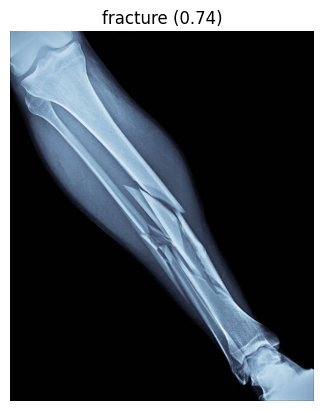

In [31]:
from google.colab import files
import cv2
from ultralytics import YOLO

model = YOLO("xray_yolo_cls_model.pt")

uploaded = files.upload()

for filename in uploaded.keys():
    img = cv2.imread(filename)
    pred = model.predict(filename)

    probs = pred[0].probs.data.cpu().numpy()
    idx = probs.argmax()
    cls = model.names[idx]
    conf = probs[idx]

    print(f"Prediction: {cls} | Confidence: {conf:.2f}")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f"{cls} ({conf:.2f})")
    plt.axis("off")
    plt.show()


In [33]:
# If your data_path currently points to the train folder, fix it:

dataset_root = "/content/drive/MyDrive/Xray_17_Diseases_Dataset"
val_dir = f"{dataset_root}/valid"


In [34]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import os

# ✅ Correct paths
dataset_root = "/content/drive/MyDrive/Xray_17_Diseases_Dataset"
val_dir = f"{dataset_root}/valid"

preds = []
true = []
class_names = model.names

for label, cls in enumerate(class_names.values()):
    folder = f"{val_dir}/{cls}"

    # skip missing folders to avoid crash
    if not os.path.exists(folder):
        print(f"⚠️ Folder missing: {folder}")
        continue

    for img_name in os.listdir(folder):
        img_path = f"{folder}/{img_name}"
        pred = model.predict(img_path, verbose=False)
        preds.append(np.argmax(pred[0].probs.data.cpu().numpy()))
        true.append(label)

print("\n✅ Classification Report:")
print(classification_report(true, preds, target_names=list(class_names.values())))

print("\n✅ Confusion Matrix:")
print(confusion_matrix(true, preds))



✅ Classification Report:
                                 precision    recall  f1-score   support

                        abscess       1.00      0.67      0.80         3
                    atelectasis       0.67      1.00      0.80         2
   atherosclerosis_of_the_aorta       1.00      0.50      0.67         2
                   cardiomegaly       1.00      0.67      0.80         3
                      emphysema       0.67      1.00      0.80         2
                       fracture       1.00      0.50      0.67         2
              hydropneumothorax       1.00      1.00      1.00         4
                    hydrothorax       1.00      1.00      1.00         2
                      pneumonia       0.50      1.00      0.67         1
                pneumosclerosis       0.00      0.00      0.00         1
      post_inflammatory_changes       0.50      0.67      0.57         3
post_traumatic_ribs_deformation       0.50      0.50      0.50         2
                    sarc